# Multi label classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.3 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_data_path = '/content/drive/MyDrive/Deep Learning/DL_major/train.csv'

In [ ]:
train_data_csv = pd.read_csv(train_data_path)
train_data_csv.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
train_data_csv['TITLE'].str.split().map(lambda x: len(x)).max()

40

In [ ]:
max_title_len = train_data_csv['TITLE'].str.split().map(lambda x: len(x)).max()
max_abstract_len = train_data_csv['ABSTRACT'].str.split().map(lambda x: len(x)).max()

extra_tokens = 20

## using their pretrained models
https://huggingface.co/princeton-nlp

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
# Load the tokenizer and model
# tokenizer = RobertaTokenizer.from_pretrained("princeton-nlp/mabel-roberta-base")
# model = RobertaModel.from_pretrained("princeton-nlp/mabel-roberta-base")

In [ ]:
title_tokens = tokenizer(train_data_csv['TITLE'].values.tolist(),
                         padding=True,
                         truncation=True,
                         max_length=max_title_len + extra_tokens,
                         return_tensors='pt')['input_ids']

abstract_tokens = tokenizer(train_data_csv['ABSTRACT'].values.tolist(),
                         padding=True,
                         truncation=True,
                         max_length=max_abstract_len + extra_tokens,
                         return_tensors='pt')['input_ids']

### custom class for creating the dataset

In [ ]:
class ClassificationDataset(Dataset):
    
    def __init__(self, csv_path, title_tokens, abstract_tokens, low_limit, high_limit):
        
        self.data = pd.read_csv(csv_path).iloc[low_limit:high_limit].reset_index(drop=True)
        self.title_tokens = title_tokens[low_limit:high_limit]
        self.abstract_tokens = abstract_tokens[low_limit:high_limit]
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return (
            self.title_tokens[idx],
            self.abstract_tokens[idx],
            self.data[self.data.columns[3]].iloc[idx],
            self.data[self.data.columns[4]].iloc[idx],
            self.data[self.data.columns[5]].iloc[idx],
            self.data[self.data.columns[6]].iloc[idx],
            self.data[self.data.columns[7]].iloc[idx],
            self.data[self.data.columns[8]].iloc[idx],
        )

In [ ]:
train_data = ClassificationDataset(train_data_path, title_tokens, abstract_tokens, 0, int(len(train_data_csv) * 0.8))
test_data = ClassificationDataset(train_data_path, title_tokens, abstract_tokens, int(len(train_data_csv) * 0.8), int(len(train_data_csv)))

In [ ]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=64, drop_last=True)

## custom classifier (DataMUX approach)

In [ ]:
class Classifier(nn.Module):
    
    def __init__(self, K):
        super(Classifier, self).__init__()
        
        self.K = K
        self.embedding = AutoModel.from_pretrained('xlm-roberta-base')
        
        for param in self.embedding.parameters():
            param.requires_grad = False
        
        self.rnn_title = nn.LSTM(input_size=768, hidden_size=64, bidirectional=True, batch_first=True)
        self.rnn_abstract = nn.LSTM(input_size=768, hidden_size=128, bidirectional=True, batch_first=True)
        
        self.multiplexing_layer = MultiplexingLayer(K, in_features=384)
        self.base_network = nn.Linear(in_features=K*384, out_features=6)
        self.demultiplexing_layer = DemultiplexingLayer(K, out_features=6)
        
        self.act = nn.Sigmoid()
        
    def forward(self, titles, abstracts):
        # titles and abstracts are lists of tensors of shape (batch_size, sequence_length)
        assert len(titles) == len(abstracts) == self.K
        
        title_embeddings = [self.embedding(t).last_hidden_state for t in titles]
        abstract_embeddings = [self.embedding(a).last_hidden_state for a in abstracts]
        
        title_features = [self.rnn_title(e)[0][:, -1, :] for e in title_embeddings]
        abstract_features = [self.rnn_abstract(e)[0][:, -1, :] for e in abstract_embeddings]
        
        combined_features = self.multiplexing_layer(title_features + abstract_features)
        combined_features = self.base_network(combined_features)
        output = self.demultiplexing_layer(combined_features)
        
        return tuple(self.act(o) for o in output)


In [ ]:
class MultiplexingLayer(nn.Module):
    def __init__(self, K, in_features):
        super().__init__()
        self.K = K
        self.weights = nn.ModuleList([nn.Linear(in_features, in_features) for i in range(K)])
        
    def forward(self, inputs):
        # inputs is a list of K tensors of shape (batch_size, hidden_size)
        assert len(inputs) == self.K
        
        transformed_inputs = []
        for i in range(self.K):
            transformed_inputs.append(self.weights[i](inputs[i]))
        
        combined_input = torch.cat(transformed_inputs, dim=1)
        
        return combined_input


class DemultiplexingLayer(nn.Module):
    def __init__(self, K, out_features):
        super().__init__()
        self.K = K
        self.weights = nn.ModuleList([nn.Linear(out_features, out_features) for i in range(K)])
        
    def forward(self, combined_output):
        # Split the combined output into K parts
        input_outputs = torch.split(combined_output, combined_output.shape[0] // self.K, dim=0)
        
        # Reconstruct the representations for each input
        output = []
        for i in range(self.K):
            output.append(self.weights[i](input_outputs[i]))
        
        return tuple(output)

In [ ]:
# class Classifier(nn.Module):
    
#     def __init__(self, K):
#         super(Classifier, self).__init__()
        
#         self.embedding = AutoModel.from_pretrained('xlm-roberta-base')
        
#         for param in self.embedding.parameters():
#             param.requires_grad = False
        
#         self.rnn_title = nn.LSTM(input_size=768, hidden_size=64, bidirectional=True, batch_first=True)
#         self.rnn_abstract = nn.LSTM(input_size=768, hidden_size=128, bidirectional=True, batch_first=True)
        
#         self.cs = nn.Linear(in_features=384, out_features=1)    # (2*(64+128) since bidirectional)
#         self.phy = nn.Linear(in_features=384, out_features=1)
#         self.math = nn.Linear(in_features=384, out_features=1)
#         self.stat = nn.Linear(in_features=384, out_features=1)
#         self.qb = nn.Linear(in_features=384, out_features=1)
#         self.qf = nn.Linear(in_features=384, out_features=1)
        
#         self.act = nn.Sigmoid()
        
#     def forward(self, title, abstract):
        
#         title_embedding = self.embedding(title).last_hidden_state
        
#         abstract_embedding = self.embedding(abstract).last_hidden_state
        
#         title_features = self.rnn_title(title_embedding)[0][:, -1, :]
#         abstract_features = self.rnn_abstract(abstract_embedding)[0][:, -1, :]
        
#         combined_features = torch.concat([title_features, abstract_features], dim=1)
        
#         cs_pred = self.act(self.cs(combined_features))
#         phy_pred = self.act(self.phy(combined_features))
#         math_pred = self.act(self.math(combined_features))
#         stat_pred = self.act(self.stat(combined_features))
#         qb_pred = self.act(self.qb(combined_features))
#         qf_pred = self.act(self.qf(combined_features))
        
#         return (
#             cs_pred,
#             phy_pred,
#             math_pred,
#             stat_pred,
#             qb_pred,
#             qf_pred
#         )

In [ ]:
K = 2  # number of inputs to process simultaneously
model = Classifier(K).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### train and test

In [ ]:
epochs = 10

for epoch in range(epochs):
    
    train_loss = 0
    train_loss_cs = 0
    train_loss_phy = 0
    train_loss_math = 0
    train_loss_stat = 0
    train_loss_qb = 0
    train_loss_qf = 0
    
    train_acc = 0
    train_acc_cs = 0
    train_acc_phy = 0
    train_acc_math = 0
    train_acc_stat = 0
    train_acc_qb = 0
    train_acc_qf = 0
    
    test_loss = 0
    test_loss_cs = 0
    test_loss_phy = 0
    test_loss_math = 0
    test_loss_stat = 0
    test_loss_qb = 0
    test_loss_qf = 0
    
    test_acc = 0
    test_acc_cs = 0
    test_acc_phy = 0
    test_acc_math = 0
    test_acc_stat = 0
    test_acc_qb = 0
    test_acc_qf = 0
    
    model.train()
    
    
    for (index, (title, abstract, cs_true, phy_true, math_true, stat_true, qb_true, qf_true)) in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        title, abstract, cs_true, phy_true, math_true, stat_true, qb_true, qf_true = title.to(device), abstract.to(device), cs_true.to(device), phy_true.to(device), math_true.to(device), stat_true.to(device), qb_true.to(device), qf_true.to(device)
        
        cs_pred, phy_pred, math_pred, stat_pred, qb_pred, qf_pred = model(title, abstract)
        
        loss_cs = loss_fn(cs_pred, cs_true.float().unsqueeze(dim=1))
        loss_phy = loss_fn(phy_pred, phy_true.float().unsqueeze(dim=1))
        loss_math = loss_fn(math_pred, math_true.float().unsqueeze(dim=1))
        loss_stat = loss_fn(stat_pred, stat_true.float().unsqueeze(dim=1))
        loss_qb = loss_fn(qb_pred, qb_true.float().unsqueeze(dim=1))
        loss_qf = loss_fn(qf_pred, qf_true.float().unsqueeze(dim=1))
        
        loss = loss_cs + loss_phy + loss_math + loss_stat + loss_qb + loss_qf
        
        train_loss_cs += loss_cs.item()
        train_loss_phy += loss_phy.item()
        train_loss_math += loss_math.item()
        train_loss_stat += loss_stat.item()
        train_loss_qb += loss_qb.item()
        train_loss_qf += loss_qf.item()
        train_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
        
        acc_cs = (cs_pred.round() == cs_true.float().unsqueeze(dim=1)).sum().item() / cs_pred.size(0)
        acc_phy = (phy_pred.round() == phy_true.float().unsqueeze(dim=1)).sum().item() / phy_pred.size(0)
        acc_math = (math_pred.round() == math_true.float().unsqueeze(dim=1)).sum().item() / math_pred.size(0)
        acc_stat = (stat_pred.round() == stat_true.float().unsqueeze(dim=1)).sum().item() / stat_pred.size(0)
        acc_qb = (qb_pred.round() == qb_true.float().unsqueeze(dim=1)).sum().item() / qb_pred.size(0)
        acc_qf = (qf_pred.round() == qf_true.float().unsqueeze(dim=1)).sum().item() / qf_pred.size(0)
        
        acc = (acc_cs + acc_phy + acc_math + acc_stat + acc_qb + acc_qf) / 6
        
        train_acc += acc
        train_acc_cs += acc_cs
        train_acc_phy += acc_phy
        train_acc_math += acc_math
        train_acc_stat += acc_stat
        train_acc_qb += acc_qb
        train_acc_qf += acc_qf
        
        print("Epoch {}: Batch: {}/{} || Loss CS: {:.4f} || Loss Phy: {:.4f} || Loss Math: {:.4f} || Loss Stat: {:.4f} || Loss QB: {:.4f} || Loss QF: {:.4f} || Loss Total: {:.4f} || Acc CS: {:.4f} || Acc Phy: {:.4f} || Acc Math: {:.4f} || Acc Stat: {:.4f} || Acc QB: {:.4f} || Acc QF: {:.4f} || Acc Total: {:.4f}".format(
            epoch+1,
            index,
            len(train_dataloader),
            loss_cs,
            loss_phy,
            loss_math,
            loss_stat,
            loss_qb,
            loss_qf,
            loss,
            acc_cs,
            acc_phy,
            acc_math,
            acc_stat,
            acc_qb,
            acc_qf,
            acc
        ), end='\r')
        
    print("Epoch Train {}: Loss CS: {:.4f} || Loss Phy: {:.4f} || Loss Math: {:.4f} || Loss Stat: {:.4f} || Loss QB: {:.4f} || Loss QF: {:.4f} || Loss Total: {:.4f} || Acc CS: {:.4f} || Acc Phy: {:.4f} || Acc Math: {:.4f} || Acc Stat: {:.4f} || Acc QB: {:.4f} || Acc QF: {:.4f} || Acc Total: {:.4f}".format(
            epoch+1,
            train_loss_cs / len(train_dataloader),
            train_loss_phy / len(train_dataloader),
            train_loss_math / len(train_dataloader),
            train_loss_stat / len(train_dataloader),
            train_loss_qb / len(train_dataloader),
            train_loss_qf / len(train_dataloader),
            train_loss / len(train_dataloader),
            train_acc_cs / len(train_dataloader),
            train_acc_phy / len(train_dataloader),
            train_acc_math / len(train_dataloader),
            train_acc_stat / len(train_dataloader),
            train_acc_qb / len(train_dataloader),
            train_acc_qf / len(train_dataloader),
            train_acc / len(train_dataloader)
        ))
    
    model.eval()
    for title, abstract, cs_true, phy_true, math_true, stat_true, qb_true, qf_true in tqdm(test_dataloader):
        
        with torch.no_grad():
            title, abstract, cs_true, phy_true, math_true, stat_true, qb_true, qf_true = title.to(device), abstract.to(device), cs_true.to(device), phy_true.to(device), math_true.to(device), stat_true.to(device), qb_true.to(device), qf_true.to(device)
        
            cs_pred, phy_pred, math_pred, stat_pred, qb_pred, qf_pred = model(title, abstract)
            
            loss_cs = loss_fn(cs_pred, cs_true.float().unsqueeze(dim=1))
            loss_phy = loss_fn(phy_pred, phy_true.float().unsqueeze(dim=1))
            loss_math = loss_fn(math_pred, math_true.float().unsqueeze(dim=1))
            loss_stat = loss_fn(stat_pred, stat_true.float().unsqueeze(dim=1))
            loss_qb = loss_fn(qb_pred, qb_true.float().unsqueeze(dim=1))
            loss_qf = loss_fn(qf_pred, qf_true.float().unsqueeze(dim=1))
        
            loss = loss_cs + loss_phy + loss_math + loss_stat + loss_qb + loss_qf
        
        test_loss_cs += loss_cs.item()
        test_loss_phy += loss_phy.item()
        test_loss_math += loss_math.item()
        test_loss_stat += loss_stat.item()
        test_loss_qb += loss_qb.item()
        test_loss_qf += loss_qf.item()
        test_loss += loss.item()
        
        acc_cs = (cs_pred.round() == cs_true.float().unsqueeze(dim=1)).sum().item() / cs_pred.size(0)
        acc_phy = (phy_pred.round() == phy_true.float().unsqueeze(dim=1)).sum().item() / phy_pred.size(0)
        acc_math = (math_pred.round() == math_true.float().unsqueeze(dim=1)).sum().item() / math_pred.size(0)
        acc_stat = (stat_pred.round() == stat_true.float().unsqueeze(dim=1)).sum().item() / stat_pred.size(0)
        acc_qb = (qb_pred.round() == qb_true.float().unsqueeze(dim=1)).sum().item() / qb_pred.size(0)
        acc_qf = (qf_pred.round() == qf_true.float().unsqueeze(dim=1)).sum().item() / qf_pred.size(0)
        
        acc = (acc_cs + acc_phy + acc_math + acc_stat + acc_qb + acc_qf) / 6
        
        test_acc += acc
        test_acc_cs += acc_cs
        test_acc_phy += acc_phy
        test_acc_math += acc_math
        test_acc_stat += acc_stat
        test_acc_qb += acc_qb
        test_acc_qf += acc_qf
        
    print("Epoch Test {}: Loss CS: {:.4f} || Loss Phy: {:.4f} || Loss Math: {:.4f} || Loss Stat: {:.4f} || Loss QB: {:.4f} || Loss QF: {:.4f} || Loss Total: {:.4f} || Acc CS: {:.4f} || Acc Phy: {:.4f} || Acc Math: {:.4f} || Acc Stat: {:.4f} || Acc QB: {:.4f} || Acc QF: {:.4f} || Acc Total: {:.4f}".format(
            epoch+1,
            test_loss_cs / len(test_dataloader),
            test_loss_phy / len(test_dataloader),
            test_loss_math / len(test_dataloader),
            test_loss_stat / len(test_dataloader),
            test_loss_qb / len(test_dataloader),
            test_loss_qf / len(test_dataloader),
            test_loss / len(test_dataloader),
            test_acc_cs / len(test_dataloader),
            test_acc_phy / len(test_dataloader),
            test_acc_math / len(test_dataloader),
            test_acc_stat / len(test_dataloader),
            test_acc_qb / len(test_dataloader),
            test_acc_qf / len(test_dataloader),
            test_acc / len(test_dataloader)
        ))

Epoch Train 1: Loss CS: 0.6243 || Loss Phy: 0.5562 || Loss Math: 0.5233 || Loss Stat: 0.5490 || Loss QB: 0.1401 || Loss QF: 0.0759 || Loss Total: 2.4688 || Acc CS: 0.6589 || Acc Phy: 0.7334 || Acc Math: 0.7551 || Acc Stat: 0.7479 || Acc QB: 0.9676 || Acc QF: 0.9882 || Acc Total: 0.8085


100%|██████████| 65/65 [02:09<00:00,  1.99s/it]


Epoch Test 1: Loss CS: 0.5848 || Loss Phy: 0.5195 || Loss Math: 0.5700 || Loss Stat: 0.5726 || Loss QB: 0.1105 || Loss QF: 0.0689 || Loss Total: 2.4263 || Acc CS: 0.6659 || Acc Phy: 0.7623 || Acc Math: 0.6815 || Acc Stat: 0.7462 || Acc QB: 0.9762 || Acc QF: 0.9870 || Acc Total: 0.8032
Epoch Train 2: Loss CS: 0.5143 || Loss Phy: 0.4409 || Loss Math: 0.4735 || Loss Stat: 0.5062 || Loss QB: 0.1239 || Loss QF: 0.0630 || Loss Total: 2.1219 || Acc CS: 0.7465 || Acc Phy: 0.8092 || Acc Math: 0.7878 || Acc Stat: 0.7449 || Acc QB: 0.9709 || Acc QF: 0.9884 || Acc Total: 0.8413


100%|██████████| 65/65 [02:08<00:00,  1.98s/it]


Epoch Test 2: Loss CS: 0.5621 || Loss Phy: 0.4953 || Loss Math: 0.5571 || Loss Stat: 0.5275 || Loss QB: 0.1081 || Loss QF: 0.0684 || Loss Total: 2.3184 || Acc CS: 0.6930 || Acc Phy: 0.7781 || Acc Math: 0.6974 || Acc Stat: 0.7478 || Acc QB: 0.9762 || Acc QF: 0.9873 || Acc Total: 0.8133
Epoch Train 3: Loss CS: 0.4654 || Loss Phy: 0.3847 || Loss Math: 0.4394 || Loss Stat: 0.4740 || Loss QB: 0.1188 || Loss QF: 0.0614 || Loss Total: 1.9438 || Acc CS: 0.7771 || Acc Phy: 0.8457 || Acc Math: 0.8036 || Acc Stat: 0.7545 || Acc QB: 0.9710 || Acc QF: 0.9884 || Acc Total: 0.8567


100%|██████████| 65/65 [02:09<00:00,  1.99s/it]


Epoch Test 3: Loss CS: 0.6243 || Loss Phy: 0.5200 || Loss Math: 0.4947 || Loss Stat: 0.5714 || Loss QB: 0.1028 || Loss QF: 0.0672 || Loss Total: 2.3804 || Acc CS: 0.6798 || Acc Phy: 0.7288 || Acc Math: 0.7728 || Acc Stat: 0.7517 || Acc QB: 0.9767 || Acc QF: 0.9873 || Acc Total: 0.8162
Epoch Train 4: Loss CS: 0.4668 || Loss Phy: 0.3909 || Loss Math: 0.4345 || Loss Stat: 0.4721 || Loss QB: 0.1156 || Loss QF: 0.0610 || Loss Total: 1.9409 || Acc CS: 0.7793 || Acc Phy: 0.8378 || Acc Math: 0.8089 || Acc Stat: 0.7657 || Acc QB: 0.9709 || Acc QF: 0.9884 || Acc Total: 0.8585


100%|██████████| 65/65 [02:08<00:00,  1.98s/it]


Epoch Test 4: Loss CS: 0.4934 || Loss Phy: 0.4387 || Loss Math: 0.4593 || Loss Stat: 0.5270 || Loss QB: 0.1032 || Loss QF: 0.0679 || Loss Total: 2.0896 || Acc CS: 0.7680 || Acc Phy: 0.8127 || Acc Math: 0.7764 || Acc Stat: 0.7575 || Acc QB: 0.9762 || Acc QF: 0.9870 || Acc Total: 0.8463
Epoch Train 5: Loss CS: 0.4442 || Loss Phy: 0.3689 || Loss Math: 0.4157 || Loss Stat: 0.4535 || Loss QB: 0.1119 || Loss QF: 0.0600 || Loss Total: 1.8542 || Acc CS: 0.7910 || Acc Phy: 0.8480 || Acc Math: 0.8178 || Acc Stat: 0.7692 || Acc QB: 0.9710 || Acc QF: 0.9884 || Acc Total: 0.8642


100%|██████████| 65/65 [02:08<00:00,  1.98s/it]


Epoch Test 5: Loss CS: 0.5037 || Loss Phy: 0.4582 || Loss Math: 0.5250 || Loss Stat: 0.5343 || Loss QB: 0.1048 || Loss QF: 0.0675 || Loss Total: 2.1935 || Acc CS: 0.7279 || Acc Phy: 0.8101 || Acc Math: 0.7522 || Acc Stat: 0.7577 || Acc QB: 0.9760 || Acc QF: 0.9870 || Acc Total: 0.8351
Epoch Train 6: Loss CS: 0.4434 || Loss Phy: 0.3567 || Loss Math: 0.4110 || Loss Stat: 0.4485 || Loss QB: 0.1072 || Loss QF: 0.0582 || Loss Total: 1.8250 || Acc CS: 0.7932 || Acc Phy: 0.8541 || Acc Math: 0.8183 || Acc Stat: 0.7712 || Acc QB: 0.9711 || Acc QF: 0.9884 || Acc Total: 0.8660


100%|██████████| 65/65 [02:08<00:00,  1.98s/it]


Epoch Test 6: Loss CS: 0.4927 || Loss Phy: 0.4455 || Loss Math: 0.4664 || Loss Stat: 0.5404 || Loss QB: 0.1031 || Loss QF: 0.0684 || Loss Total: 2.1165 || Acc CS: 0.7620 || Acc Phy: 0.8058 || Acc Math: 0.7918 || Acc Stat: 0.7601 || Acc QB: 0.9764 || Acc QF: 0.9870 || Acc Total: 0.8472
Epoch Train 7: Loss CS: 0.4309 || Loss Phy: 0.3395 || Loss Math: 0.3946 || Loss Stat: 0.4373 || Loss QB: 0.1053 || Loss QF: 0.0579 || Loss Total: 1.7656 || Acc CS: 0.8006 || Acc Phy: 0.8647 || Acc Math: 0.8295 || Acc Stat: 0.7769 || Acc QB: 0.9714 || Acc QF: 0.9884 || Acc Total: 0.8719


100%|██████████| 65/65 [02:09<00:00,  1.99s/it]


Epoch Test 7: Loss CS: 0.5185 || Loss Phy: 0.4462 || Loss Math: 0.4566 || Loss Stat: 0.5843 || Loss QB: 0.1005 || Loss QF: 0.0661 || Loss Total: 2.1722 || Acc CS: 0.7310 || Acc Phy: 0.8127 || Acc Math: 0.7837 || Acc Stat: 0.7572 || Acc QB: 0.9764 || Acc QF: 0.9870 || Acc Total: 0.8413
Epoch Train 8: Loss CS: 0.4302 || Loss Phy: 0.3395 || Loss Math: 0.3811 || Loss Stat: 0.4366 || Loss QB: 0.1039 || Loss QF: 0.0563 || Loss Total: 1.7477 || Acc CS: 0.7996 || Acc Phy: 0.8660 || Acc Math: 0.8358 || Acc Stat: 0.7781 || Acc QB: 0.9713 || Acc QF: 0.9884 || Acc Total: 0.8732


100%|██████████| 65/65 [02:08<00:00,  1.98s/it]


Epoch Test 8: Loss CS: 0.5084 || Loss Phy: 0.4459 || Loss Math: 0.4892 || Loss Stat: 0.5382 || Loss QB: 0.1005 || Loss QF: 0.0621 || Loss Total: 2.1442 || Acc CS: 0.7526 || Acc Phy: 0.8075 || Acc Math: 0.7738 || Acc Stat: 0.7603 || Acc QB: 0.9755 || Acc QF: 0.9870 || Acc Total: 0.8428
Epoch Train 9: Loss CS: 0.4189 || Loss Phy: 0.3251 || Loss Math: 0.3761 || Loss Stat: 0.4299 || Loss QB: 0.1019 || Loss QF: 0.0534 || Loss Total: 1.7053 || Acc CS: 0.8058 || Acc Phy: 0.8707 || Acc Math: 0.8364 || Acc Stat: 0.7805 || Acc QB: 0.9714 || Acc QF: 0.9884 || Acc Total: 0.8755


100%|██████████| 65/65 [02:08<00:00,  1.98s/it]


Epoch Test 9: Loss CS: 0.4900 || Loss Phy: 0.4381 || Loss Math: 0.4746 || Loss Stat: 0.5498 || Loss QB: 0.0998 || Loss QF: 0.0619 || Loss Total: 2.1142 || Acc CS: 0.7529 || Acc Phy: 0.8183 || Acc Math: 0.7798 || Acc Stat: 0.7625 || Acc QB: 0.9752 || Acc QF: 0.9873 || Acc Total: 0.8460
Epoch Train 10: Loss CS: 0.4213 || Loss Phy: 0.3208 || Loss Math: 0.3654 || Loss Stat: 0.4281 || Loss QB: 0.1009 || Loss QF: 0.0523 || Loss Total: 1.6888 || Acc CS: 0.8030 || Acc Phy: 0.8737 || Acc Math: 0.8451 || Acc Stat: 0.7805 || Acc QB: 0.9715 || Acc QF: 0.9884 || Acc Total: 0.8770


100%|██████████| 65/65 [02:09<00:00,  1.99s/it]

Epoch Test 10: Loss CS: 0.4828 || Loss Phy: 0.4469 || Loss Math: 0.4488 || Loss Stat: 0.5265 || Loss QB: 0.0976 || Loss QF: 0.0617 || Loss Total: 2.0643 || Acc CS: 0.7675 || Acc Phy: 0.8014 || Acc Math: 0.7959 || Acc Stat: 0.7649 || Acc QB: 0.9762 || Acc QF: 0.9873 || Acc Total: 0.8489


In [13]:
train_acc = [80.85, 84.13, 85.67, 85.85, 86.42, 86.60, 87.19, 87.32, 87.55, 87.70]
test_acc = [80.32, 81.33, 81.62, 84.43, 83.51, 84.62, 84.13, 84.28, 84.60, 85.89]
epochs = [i for i in range(1,11)]

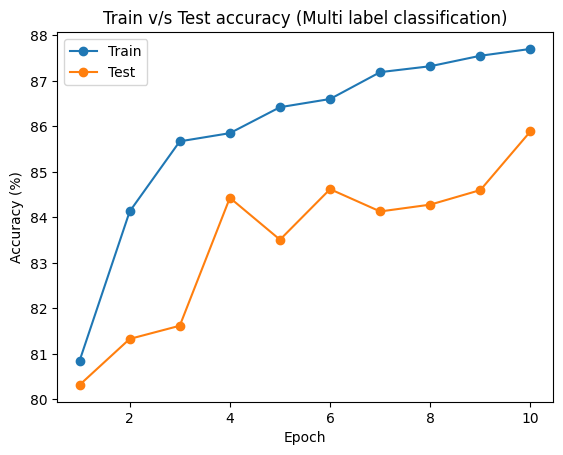

In [14]:
import matplotlib.pyplot as plt
plt.plot(epochs, train_acc, 'o-', label='Train')
plt.plot(epochs, test_acc,'o-', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train v/s Test accuracy (Multi label classification)')
plt.show()